### Molecular Feature Vector Construction

For each molecule (node), create a feature vector by concatenating:
- a) Molecular Fingerprint: This is already a high-dimensional vector.
- b) Scalar Properties: Convert each scalar property (e.g., molecular weight, heavy atom count) into a one-hot or multi-hot encoding, or embed them into a higher-dimensional space.
From the available columns, let's select the following features for our vector:

Fingerprint (already a 2048-dimensional vector)
mapped_protein_class (categorical)
map_target_taxonomy (categorical)
map_target_organism (categorical)

In [36]:
import warnings
from tqdm import tqdm
import tmap as tm
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit import Chem
from mapchiral.mapchiral import encode as mapc_enc
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging
import pickle
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import html

import warnings
from tqdm import tqdm
import tmap as tm
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit import Chem
from mapchiral.mapchiral import encode as mapc_enc
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging
import pickle
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import html

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
from tqdm import tqdm
import tmap as tm
from timeit import default_timer as timer
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit import Chem
from mapchiral.mapchiral import encode as mapc_enc
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging
import pickle
from pathlib import Path
from rdkit.Chem import Descriptors, rdMolDescriptors
import html

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder



# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def encode_smiles(smiles, encoder):
    """
    Helper function to encode a single SMILES string based on the specified encoder.

    Args:
    smiles (str): The SMILES string to encode.
    encoder (str): The encoding method, 'mhfp' or 'mapc'.
    kwargs: Additional arguments for the encoder.

    Returns:
    tm.VectorUint: Encoded fingerprint.
    """
    if encoder == 'mapc':
        return tm.VectorUint(mapc_enc(Chem.MolFromSmiles(smiles), max_radius=2, n_permutations=2048, mapping=False))
    elif encoder == 'mhfp':
        perm = 512
        mhfp_enc = MHFPEncoder(perm)
        return tm.VectorUint(mhfp_enc.encode(smiles))
    return None

def calculate_threshold(data):
    # Function to calculate threshold using IQR method
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    threshold = q3 + 1.5 * iqr
    return threshold

def calculate_molecular_properties(smiles):
    """
    Calculate molecular properties using RDKit.
    
    Args:
    smiles (str): SMILES string of the molecule.
    
    Returns:
    tuple: (HAC, fraction_aromatic_atoms, number_of_rings, clogP, fraction_Csp3)
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    hac = mol.GetNumHeavyAtoms()
    num_aromatic_atoms = sum(1 for atom in mol.GetAtoms() if atom.GetIsAromatic())
    fraction_aromatic_atoms = num_aromatic_atoms / hac if hac > 0 else 0
    number_of_rings = rdMolDescriptors.CalcNumRings(mol)
    clogP = Descriptors.MolLogP(mol)
    fraction_Csp3 = Descriptors.FractionCSP3(mol)
    
    return (hac, fraction_aromatic_atoms, number_of_rings, clogP, fraction_Csp3)

def calculate_fingerprints(df, encoder):
    """
    Calculate fingerprints for SMILES strings in the dataframe.
    
    Args:
    df (pandas.DataFrame): DataFrame containing 'canonical_smiles' column.
    encoder (str): The encoder object used to encode SMILES strings ('mhfp' or 'mapc').
    
    Returns:
    tuple: (list of encoded fingerprints, list of valid indices).
    """
    fingerprints = []
    valid_indices = []

    for idx, smiles in enumerate(tqdm(df['canonical_smiles'], desc=f"Calculating fingerprints ({encoder})")):
        try:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                enc_fingerprint = encode_smiles(smiles, encoder)
                if w and issubclass(w[-1].category, UserWarning):
                    logger.warning(f"Warning for Fingerprints {smiles}: {str(w[-1].message)}")
                    continue
            fingerprints.append(enc_fingerprint)
            valid_indices.append(idx)
        except Exception as e:
            logger.error(f"Error encoding Fingerprints {smiles}: {str(e)}")
        
    return fingerprints, valid_indices

def list_to_vectorUint(lst):
    """
    Convert list or numpy array to tm.VectorUint type.
    
    Args:
    lst (list or np.array): The list or array to convert.
    
    Returns:
    tm.VectorUint: Converted VectorUint object.
    """
    return tm.VectorUint(lst)

def safe_create_categories(series):
    """
    Create categories from a pandas Series, handling NaN values.
    
    Args:
    series (pandas.Series): The input data series.
    
    Returns:
    tuple: (labels, data) for Faerun plotting.
    """
    return Faerun.create_categories(series.fillna('Unknown').astype(str))

def map_protein_class(value):
    """Map protein class to a simplified category."""
    if pd.isna(value):
        return str('NaN')
        
    if 'enzyme' in value:
            return 'Enzyme'
    elif 'membrane receptor' in value: 
        return 'Membrane receptor'
    elif ' ion channel' in value:
        return 'Ion Channel'
    elif 'transcription factor' in value: 
        return 'Transcription factor'
    elif 'epigenetic regulator' in value:
        return 'Epigenetic regulator'
    elif 'cytosolic protein' in value:
        return 'cytosolic protein'
    else:
        return 'Other'

def map_target_taxonomy(value):

    if 'Eukaryotes' in value:
        if 'Oxidoreductase' in value:
            return 'Oxidoreductase'
        elif 'Transferase' in value:
            return 'Transferase' 
        elif 'Hydrolase' in value:
            return 'Hydrolase'
        else:
            return 'Eukaryotes'
    elif 'Bacteria' in value: 
        return 'Bacteria'
    elif 'Fungi' in value:
        return 'Fungi'
    elif 'Viruses' in value: 
        return 'Viruses'
    elif 'unclassified' in value:
        return 'Unclassified'
    else:
        return 'Other'

def map_target_organism(value):

    """Map target organism to a simplified category."""
    if 'sapiens' in value:
        return 'Homo sapiens'
    elif 'virus' in value:
        return 'Virus'
    elif any(organism in value for organism in ['rattus', 'Musculus']):
        return 'Rat'
    elif 'taurus' in value:
        return 'Bovid'
    elif any(organism in value for organism in ['scrofa', 'Macaca', 'porcellus', 'oryctolagus', 'canis', 'Cricetulus']):
        return 'Other mammals'
    elif any(bacteria in value for bacteria in ['Mycobacterium', 'Escherichia', 'Salmonella', 'Staphylococcus', 'Pseudomonas', 'Bacillus', 'Acinetobacter']):
        return 'Bacteria'
    elif any(parasite in value for parasite in ['Plasmodium', 'Trypanosoma', 'Schistosoma', 'Leishmania']):
        return 'Parasites'
    else:
        return 'Others'

def select_value(group):
    """Select the correct value based on the 'standard_type' category."""
    greater_value_terms = ['Activity', 'Inhibition', 'Potency', '% Inhibition', 'Percent Effect']
    
    # Check if the standard_type is in the greater_value_terms
    if group['standard_type'].iloc[0] in greater_value_terms:
        # If the standard_type is in the list, select the row with the maximum standard_value
        return group.loc[group['standard_value'].idxmax()]
    else:
        # Otherwise, select the row with the minimum standard_value
        return group.loc[group['standard_value'].idxmin()]
    
def minhash_fingerprints(df, fingerprints, valid_indices):
    """
    Combine fingerprints by taking the minimum values for identical targets.
    
    Args:
    df (pandas.DataFrame): The DataFrame with target IDs.
    fingerprints (list): List of tm.VectorUint fingerprints.
    valid_indices (list): Indices of valid entries in the original DataFrame.
    
    Returns:
    pandas.Series: Combined fingerprints as tm.VectorUint.
    """
    df_processed = df.loc[valid_indices].copy()
    df_processed['fingerprint_vector'] = pd.Series(fingerprints, index=valid_indices)
    df_processed['fingerprint_vector'] = df_processed['fingerprint_vector'].apply(np.array)

    result = df_processed.groupby('Target_ID').agg({
        'fingerprint_vector': lambda x: np.min(np.vstack(x), axis=0).tolist(),
        **{col: 'first' for col in df_processed.columns if col not in ['fingerprint_vector', 'Target_ID']}
    }).reset_index()
    
    return result['fingerprint_vector']

def plot_faerun(x, y, s, t, df):

    """
    Plot the data using Faerun.
    
    Args:
    x (list): X coordinates.
    y (list): Y coordinates.
    s (list): Source nodes for tree plot.
    t (list): Target nodes for tree plot.
    df (pandas.DataFrame): DataFrame with target data.
    """
    f = Faerun(view="front", coords=False, clear_color="#FFFFFF")

    # Create categories
    protein_class_labels, protein_class_data = safe_create_categories(df['mapped_protein_class'])
    taxonomy_labels, taxonomy_data = safe_create_categories(df['map_target_taxonomy'])
    organism_labels, organism_data = safe_create_categories(df['map_target_organism'])

    labels = []
    hac_data = []
    frac_aromatic_data = []
    num_rings_data = []
    clogp_data = []
    frac_csp3_data = []

    for i, row in df.iterrows():
        target_name = str(row["target_name"]).strip()  # Convert to string and remove leading/trailing whitespace
        target_name = html.escape(target_name)  # Escape special characters
        
        if not target_name:
            target_name = "N/A"  # Provide a default value if empty
        
        labels.append(
            row['canonical_smiles']
            + '__'
            + f'<a target="_blank" href="https://www.ebi.ac.uk/chembl/target_report_card/{row["Target_ID"]}">{target_name}</a><br>'
        )
        
        # Calculate molecular properties
        properties = calculate_molecular_properties(row['canonical_smiles'])
        if properties:
            hac, frac_aromatic, num_rings, clogp, frac_csp3 = properties
            hac_data.append(hac)
            frac_aromatic_data.append(frac_aromatic)
            num_rings_data.append(num_rings)
            clogp_data.append(clogp)
            frac_csp3_data.append(frac_csp3)
        else:
            # Handle invalid SMILES
            hac_data.append(None)
            frac_aromatic_data.append(None)
            num_rings_data.append(None)
            clogp_data.append(None)
            frac_csp3_data.append(None)
   
    # Calculate threshold for hac_data using IQR
    hac_threshold = calculate_threshold(hac_data)
    frac_threshold = calculate_threshold(frac_aromatic_data)
    rings_threshold = calculate_threshold(num_rings_data)
    clogp_threshold = calculate_threshold(clogp_data)
    csp3_threshold = calculate_threshold(frac_csp3_data)

    # Function to apply thresholds and return filtered data as separate lists
    def apply_thresholds(hac_data, frac_aromatic_data, num_rings_data, clogp_data, frac_csp3_data):
        filtered_hac = []
        filtered_frac_aromatic = []
        filtered_num_rings = []
        filtered_clogp = []
        filtered_frac_csp3 = []

        # Iterate through all data points and apply thresholds
        for hac, frac, rings, clogp, csp3 in zip(hac_data, frac_aromatic_data, num_rings_data, clogp_data, frac_csp3_data):
            if hac <= hac_threshold and frac <= frac_threshold and rings <= rings_threshold and clogp <= clogp_threshold and csp3 <= csp3_threshold:
                filtered_hac.append(hac)
                filtered_frac_aromatic.append(frac)
                filtered_num_rings.append(rings)
                filtered_clogp.append(clogp)
                filtered_frac_csp3.append(csp3)

        return filtered_hac, filtered_frac_aromatic, filtered_num_rings, filtered_clogp, filtered_frac_csp3

    filtered_hac,filtered_frac_aromatic, filtered_num_rings, filtered_clogp, filtered_frac_csp3 = apply_thresholds(hac_data, frac_aromatic_data, num_rings_data, clogp_data, frac_csp3_data)

    # Add scatter plot
    f.add_scatter(
        "mapc_targets",
        {
            "x": x,
            "y": y,
            "c": [protein_class_data, taxonomy_data, organism_data, 
                  filtered_hac, filtered_frac_aromatic, filtered_num_rings, filtered_clogp, filtered_frac_csp3],
            "labels": labels,
        },
        shader="smoothCircle",
        point_scale=4.0,
        max_point_size=20,
        interactive=True,
        legend_labels=[protein_class_labels, taxonomy_labels, organism_labels],
        categorical=[True, True, True, False, False, False, False, False],
        colormap=['tab10', 'tab10', 'tab10', 'viridis', 'viridis', 'viridis', 'viridis', 'viridis'],
        series_title=['Protein Class', 'Target Taxonomy', 'Target Organism',
                      'HAC', 'Fraction Aromatic Atoms', 'Number of Rings', 'clogP', 'Fraction Csp3'],
        has_legend=True,
    )

    # Add tree
    f.add_tree("mapc_targets_tree", {"from": s, "to": t}, point_helper="mapc_targets", color="#222222")
    
    # Plot
    f.plot('mapc_targets', template='smiles')

def create_feature_vector(fingerprint, df_row, encoders):
    """
    Create a feature vector for a single molecule.
    
    Args:
    fingerprint (VectorUint): The 2048-bit fingerprint vector
    df_row (pandas.Series): A row from the DataFrame containing other features
    encoders (dict): Dictionary of fitted encoders for categorical variables
    
    Returns:
    numpy.array: The concatenated feature vector
    """
    # Convert fingerprint to numpy array
    fp_array = np.array(fingerprint)
    
    # Normalize standard_value
    # standard_value = encoders['standard_value'].transform([[df_row['standard_value']]])[0]
    
    # One-hot encode categorical variables
    categorical_columns = ['mapped_protein_class', 'map_target_taxonomy', 'map_target_organism']
    categorical_features = []
    for col in categorical_columns:
        # Create a DataFrame with the column name to avoid the warning
        feature_df = pd.DataFrame({col: [df_row[col]]})
        encoded = encoders[col].transform(feature_df)
        categorical_features.append(encoded.toarray()[0])
    
    # Concatenate all features
    return np.concatenate([fp_array] + categorical_features)

def prepare_encoders(df):
    """
    Prepare encoders for the dataset.
    
    Args:
    df (pandas.DataFrame): The complete dataset
    
    Returns:
    dict: A dictionary of fitted encoders
    """
    encoders = {}
    
    # # StandardScaler for standard_value
    # encoders['standard_value'] = StandardScaler().fit(df[['standard_value']])
    
    # OneHotEncoder for categorical variables
    categorical_columns = ['mapped_protein_class', 'map_target_taxonomy', 'map_target_organism']
    for col in categorical_columns:
        encoders[col] = OneHotEncoder(sparse=True, handle_unknown='ignore').fit(df[[col]])
    
    return encoders

def create_feature_vectors(fingerprints, df):
    """
    Create feature vectors for all molecules in the dataset.
    
    Args:
    fingerprints (list): List of fingerprint vectors
    df (pandas.DataFrame): DataFrame containing other molecular features
    
    Returns:
    list: List of feature vectors for all molecules
    """
    encoders = prepare_encoders(df)
    feature_vectors = []
    
    for fingerprint, (_, row) in zip(fingerprints, df.iterrows()):
        feature_vector = create_feature_vector(fingerprint, row, encoders)
        feature_vectors.append(feature_vector)
    
    return feature_vectors

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Main
csv_file = r"C:\Users\biolab\Desktop\Alex\Alex's\OneDrive\Work\GNN-tmap-layout\data\dataset.csv"
df = pd.read_csv(csv_file)

# Define the path for saving/loading fingerprints
fingerprints_file = Path(r"C:\Users\biolab\Desktop\Alex\Alex's\OneDrive\Work\GNN-tmap-layout\data\fused_fingerprints.pkl")

if fingerprints_file.exists():
    logger.info('Loading pre-calculated fingerprints')
    with open(fingerprints_file, 'rb') as f:
        data = pickle.load(f)
    fused_fingerprints = data['fused_fingerprints']
    logger.info(f'Total fused fingerprints: {len(fused_fingerprints)}')
    valid_indices = data['valid_indices']
    
else:
    logger.info('Calculating fingerprints')
    # Calculate fingerprints
    fingerprints, valid_indices = calculate_fingerprints(df, 'mapc')
    # Combine fingerprints
    logger.info('Combining fingerprints')
    fused_fingerprints = minhash_fingerprints(df, fingerprints, valid_indices) 
    fused_fingerprints = fused_fingerprints.apply(list_to_vectorUint)
    logger.info(f'Combination successful. Total fused fingerprints: {len(fused_fingerprints)}')
    
    # Save the calculated fingerprints and valid_indices
    with open(fingerprints_file, 'wb') as f:
        pickle.dump({
            'fused_fingerprints': [list(fp) for fp in fused_fingerprints],
            'valid_indices': valid_indices
        }, f)
    logger.info('Saved calculated fingerprints for future use')

fingerprints, valid_indices = calculate_fingerprints(df, 'mapc')

# Filter DataFrame
df = df.iloc[valid_indices].reset_index(drop=True)
df.insert(1, "fingerprints", fingerprints)
df = df.groupby('Target_ID').apply(select_value).reset_index(drop=True) # group by Target ID and then value so the most active compound is the one that remains with the fused fp

# Apply the mapping function to the column to reduce number of unique values and make it color codeable 
df['mapped_protein_class'] = df['target_protein_class'].apply(map_protein_class)
df['map_target_taxonomy'] = df['Target_Taxonomy'].apply(map_target_taxonomy)
df['map_target_organism'] = df['Target_organism'].apply(map_target_organism)

# TMAP layout and indexing
logger.info('Indexing...')
lf = tm.LSHForest(512, 128, store=True)

# Convert back to VectorUint if loading from file
if isinstance(fused_fingerprints[0], list):
    fused_fingerprints = [tm.VectorUint(fp) for fp in fused_fingerprints]

# Get the KNN graph
from_nodes = tm.VectorUint()
to_nodes = tm.VectorUint()
weights = tm.VectorFloat()
k = 10
kc = 10

lsh_forest = tm.LSHForest(d=128, l=8, store=True, file_backed=False, weighted=False)
lsh_forest.batch_add(fused_fingerprints)
lsh_forest.index()
lsh_forest.get_knn_graph(from_nodes, to_nodes, weights, k, kc)

INFO:__main__:Loading pre-calculated fingerprints
INFO:__main__:Total fused fingerprints: 20
Calculating fingerprints (mapc): 100%|██████████| 38370/38370 [12:45<00:00, 50.14it/s]  
INFO:__main__:Indexing...


In [37]:
feature_vectors = create_feature_vectors(fingerprints, df)

In [38]:
len(feature_vectors)

7016

In [39]:
print("from nodes shape:", np.array(from_nodes).shape)
print("to nodes shape:", np.array(to_nodes).shape)
print("weights shape:", np.array(weights).shape)

from nodes shape: (200,)
to nodes shape: (200,)
weights shape: (200,)


The resulting feature vector will have the following dimensions:

Fingerprint: 2048
mapped_protein_class: n_classes
map_target_taxonomy: n_taxonomies
map_target_organism: n_organisms

### PyTorch DataSet
PyTorch Dataset class to handle the data

In [40]:
import torch
from torch.utils.data import Dataset

class MoleculeDataset(Dataset):
    def __init__(self, feature_vectors, from_nodes, to_nodes, weights):
        self.feature_vectors = torch.FloatTensor(feature_vectors)
        self.from_nodes = torch.LongTensor(from_nodes)
        self.to_nodes = torch.LongTensor(to_nodes)
        self.weights = torch.FloatTensor(weights)

    def __len__(self):
        return len(self.feature_vectors)

    def __getitem__(self, idx):
        return self.feature_vectors[idx], (self.from_nodes[idx], self.to_nodes[idx]), self.weights[idx]

# Usage
dataset = MoleculeDataset(np.array(feature_vectors), from_nodes, to_nodes, weights)

#### Data Loader

In [41]:
from torch.utils.data import DataLoader

batch_size = 32  # Adjust based on your GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#### NodeMLP Model

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class NodeMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NodeMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Usage
input_dim = len(feature_vectors[1])  # Dimension of feature vectors
hidden_dim = 256  # Adjustabke
output_dim = 2    # 2D layout
model = NodeMLP(input_dim, hidden_dim, output_dim)

#### Loss Function

In [43]:
def layout_loss(pred_pos, edge_index, edge_attr):
    # Unpack edge_index
    from_nodes, to_nodes = edge_index
    
    if len(from_nodes) == 0:  # No edges in this batch
        # Only use global loss
        centroid = pred_pos.mean(dim=0)
        return -torch.mean(torch.norm(pred_pos - centroid, dim=1))
    
    # Local structure preservation
    dist_pred = torch.norm(pred_pos[from_nodes] - pred_pos[to_nodes], dim=1)
    local_loss = F.mse_loss(dist_pred, edge_attr)

    # Global structure preservation (encourage spread)
    centroid = pred_pos.mean(dim=0)
    global_loss = -torch.mean(torch.norm(pred_pos - centroid, dim=1))

    return local_loss + 0.1 * global_loss  # Adjust the weight as needed

In [44]:
for batch_features, (from_nodes, to_nodes), weights in dataloader:
    print(weights.shape)
    print(from_nodes.shape)
    print(to_nodes.shape)
    print(batch_features.shape)


IndexError: index 378 is out of bounds for dimension 0 with size 200

In [10]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100  # Adjust as needed

for epoch in range(num_epochs):
    total_loss = 0
    for batch_features, edge_index, edge_attr in dataloader:
        optimizer.zero_grad()
        
        # Forward pass
        pred_pos = model(batch_features)
        
        # Compute loss
        loss = layout_loss(pred_pos, edge_index, edge_attr)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}")

Epoch 1/100, Loss: 103473307648.0
Epoch 2/100, Loss: 19443939328.0
Epoch 3/100, Loss: 2228595720192.0
Epoch 4/100, Loss: 167125368832.0
Epoch 5/100, Loss: 122960011264.0
Epoch 6/100, Loss: 3167969607680.0
Epoch 7/100, Loss: 1265264885760.0
Epoch 8/100, Loss: 336290643968.0
Epoch 9/100, Loss: 763579334656.0
Epoch 10/100, Loss: 3498975690752.0
Epoch 11/100, Loss: 424585330688.0
Epoch 12/100, Loss: 173138673664.0
Epoch 13/100, Loss: 203390369792.0
Epoch 14/100, Loss: 411156676608.0
Epoch 15/100, Loss: 3112205549568.0
Epoch 16/100, Loss: 2408599519232.0
Epoch 17/100, Loss: 290966175744.0
Epoch 18/100, Loss: 284324888576.0
Epoch 19/100, Loss: 65888227328.0
Epoch 20/100, Loss: 53398106112.0
Epoch 21/100, Loss: 309319761920.0
Epoch 22/100, Loss: 303288385536.0
Epoch 23/100, Loss: 617432940544.0
Epoch 24/100, Loss: 772384817152.0
Epoch 25/100, Loss: 210713034752.0
Epoch 26/100, Loss: 136837013504.0
Epoch 27/100, Loss: 254124490752.0
Epoch 28/100, Loss: 61678112768.0
Epoch 29/100, Loss: 6452313

In [45]:
model.eval()
with torch.no_grad():
    all_features = torch.FloatTensor(np.array(feature_vectors))
    layout_positions = model(all_features).numpy()

In [46]:
layout_positions

array([[434349.16  , 317627.06  ],
       [ 74713.21  , 106079.484 ],
       [257280.48  , 259903.97  ],
       ...,
       [ 70198.46  ,   7474.1323],
       [ 87371.71  ,   5600.3257],
       [ 12220.679 ,  21774.078 ]], dtype=float32)

In [47]:
x = []
y = []
for idx, coordinates in enumerate(layout_positions):
    x.append(coordinates[0])
    y.append(coordinates[1])

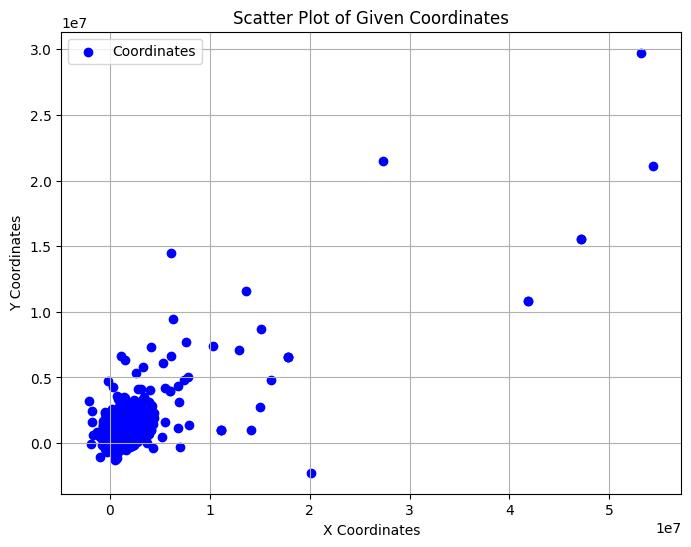

In [48]:
import matplotlib.pyplot as plt

# Plotting the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='b', label='Coordinates')
plt.title('Scatter Plot of Given Coordinates')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.grid(True)
plt.legend()
plt.show()


In [28]:
from matplotlib import pyplot as plt


26682.203